In [1]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [4]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/cleaned"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/cleaned/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/cleaned/Testing"
image_size = (256,256)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))


In [7]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

In [8]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [26]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load the ResNet152 model with pre-trained weights
resnet = models.resnet152(pretrained=True)

# Freeze the existing weights
for param in resnet.parameters():
    param.requires_grad = False

import torch
import torch.nn as nn
from torchvision import models

class CustomResNet152(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomResNet152, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
        
        # Modify the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = CustomResNet152().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr=0.001)

c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
def train_epoch():
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [21]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [22]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_score = float("inf")
n_epochs = 40
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   Train Loss: 1.0261, Train Accuracy: 71.59%
Eval Loss: 0.9954, Eval Accuracy: 73.59%
Epoch 1,   Train Loss: 0.9397, Train Accuracy: 80.15%
Eval Loss: 0.9283, Eval Accuracy: 81.83%
Epoch 2,   Train Loss: 0.9258, Train Accuracy: 81.46%
Eval Loss: 0.9430, Eval Accuracy: 79.24%
Epoch 3,   Train Loss: 0.9276, Train Accuracy: 81.32%
Eval Loss: 0.8974, Eval Accuracy: 83.82%
Epoch 4,   Train Loss: 0.9100, Train Accuracy: 83.14%
Eval Loss: 0.8901, Eval Accuracy: 85.19%
Epoch 5,   Train Loss: 0.9095, Train Accuracy: 83.05%
Eval Loss: 0.9113, Eval Accuracy: 82.44%
Epoch 6,   Train Loss: 0.9031, Train Accuracy: 83.91%
Eval Loss: 0.9264, Eval Accuracy: 81.53%
Epoch 7,   Train Loss: 0.9030, Train Accuracy: 83.58%
Eval Loss: 0.9064, Eval Accuracy: 83.36%
Epoch 8,   Train Loss: 0.9026, Train Accuracy: 83.84%
Eval Loss: 0.8964, Eval Accuracy: 84.73%
Epoch 9,   Train Loss: 0.8920, Train Accuracy: 84.80%
Eval Loss: 0.8712, Eval Accuracy: 86.72%
Epoch 10,   Train Loss: 0.8978, Train Accuracy: 84

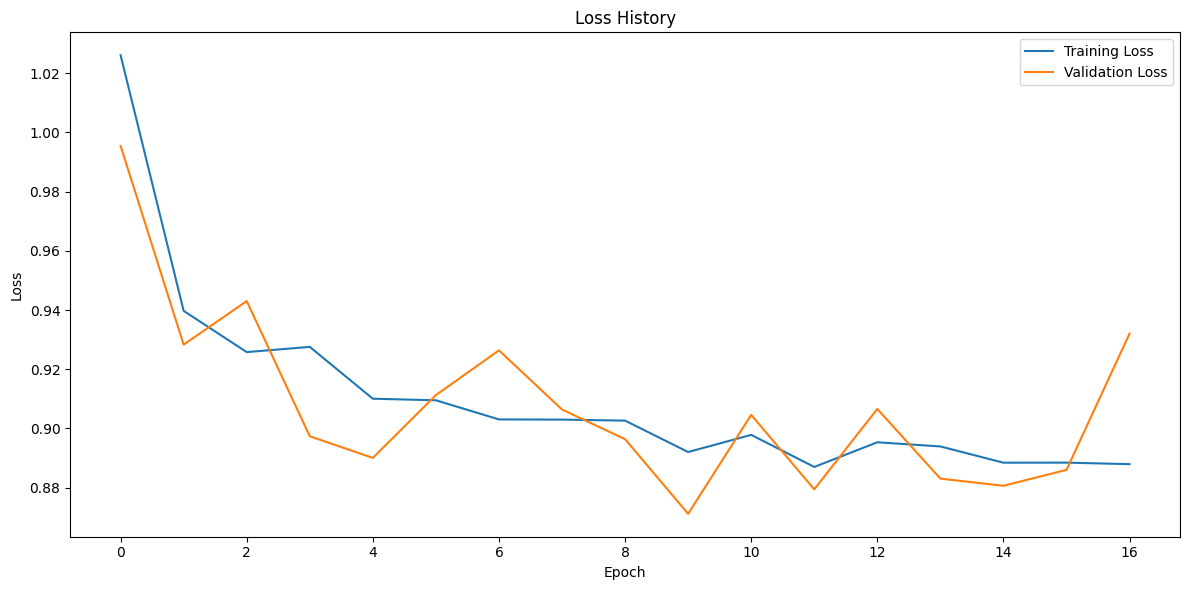

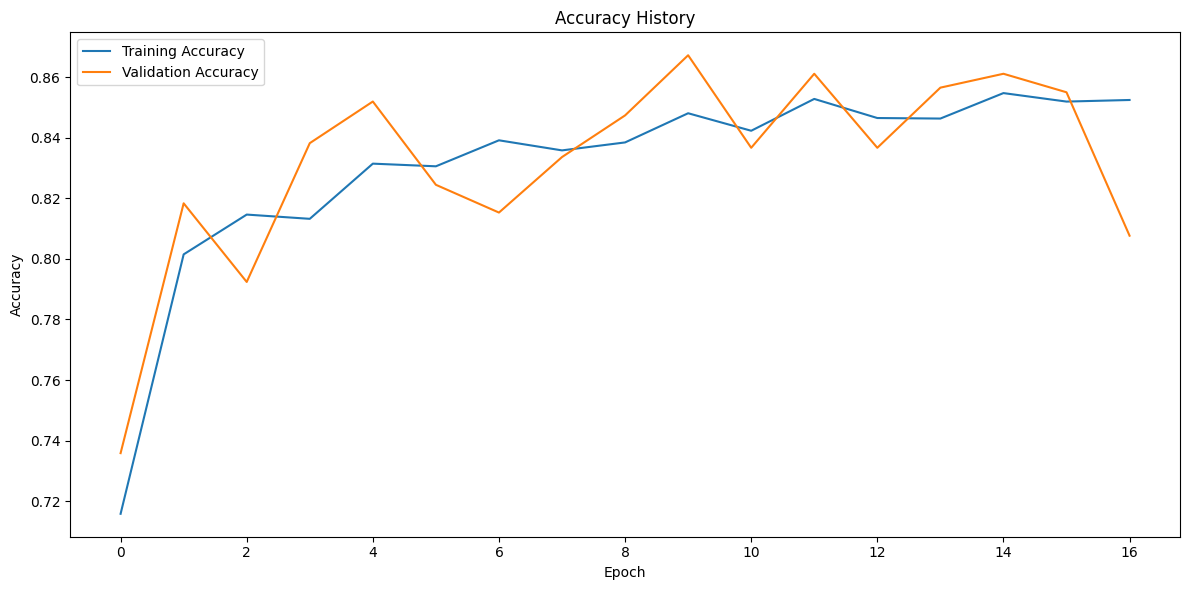

In [23]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [24]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/reseach/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_" + str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_10'

In [27]:
best_model =  CustomResNet152().to(device)
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in torch.load(best_model_path, map_location=device).items() if k in model_dict}
model_dict.update(pretrained_dict)
best_model.load_state_dict(model_dict)


<All keys matched successfully>

In [28]:

def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [29]:

best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

656

In [30]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)


656

In [31]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 86.28%


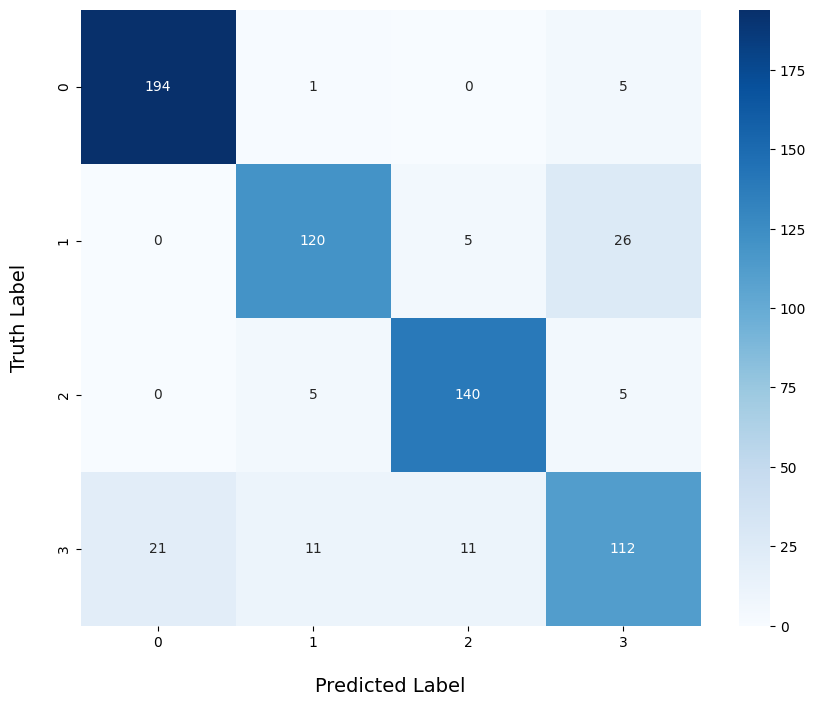

Class: 0
  Precision: 0.9023255813953488
  Recall: 0.97
  F1 Score: 0.9349397590361446
Class: 1
  Precision: 0.8759124087591241
  Recall: 0.7947019867549668
  F1 Score: 0.8333333333333334
Class: 2
  Precision: 0.8974358974358975
  Recall: 0.9333333333333333
  F1 Score: 0.9150326797385621
Class: 3
  Precision: 0.7567567567567568
  Recall: 0.7225806451612903
  F1 Score: 0.7392739273927392


In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = sorted(set(gen_labels_test_set))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

precision_per_class = precision_score(gen_labels_test_set, best_model_preds, average=None)
recall_per_class = recall_score(gen_labels_test_set, best_model_preds, average=None)
f1_per_class = f1_score(gen_labels_test_set, best_model_preds, average=None)

for i, label in enumerate(labels):
    print(f'Class: {label}')
    print(f'  Precision: {precision_per_class[i]}')
    print(f'  Recall: {recall_per_class[i]}')
    print(f'  F1 Score: {f1_per_class[i]}')
